In [1]:
import pandas as pd
import numpy as np
import json
import requests
import os

In [2]:
# lets utilize the NPS api to get as much data as we can about the National Parks and the supply of campsites

In [3]:
# first lets explore the parks endpoint to see what data you get
endpoint = "https://developer.nps.gov/api/v1/parks"
key = os.getenv("NPSKEY")
parameters = {"limit":50, "start":0, "api_key":key}
response = requests.get(url=endpoint, params=parameters)
data = json.loads(response.content)

In [4]:
# first lets see the keys
print(data.keys(),"\n")

# now lets explore
print("There are {0} total parks".format(data['total']), "\n")

# now lets explore
print("There request we sent had a limit of {0} total parks".format(data['limit']),"\n")

# now lets explore
print("There request we sent started with park number {0}".format(data['start']),"\n")

print("the 'data' is type {0} and has {1} elements".format(type(data['data']),len(data['data'])),"\n")

print("the 'data' for park 0 is type {0} and has {1} keys".format(type(data['data'][0]),
                                                                  len(data['data'][0].keys())),"\n")

print("the information for each park is {0}".format(list(data['data'][0].keys())))

dict_keys(['total', 'data', 'limit', 'start']) 

There are 497 total parks 

There request we sent had a limit of 50 total parks 

There request we sent started with park number 1 

the 'data' is type <class 'list'> and has 50 elements 

the 'data' for park 0 is type <class 'dict'> and has 22 keys 

the information for each park is ['contacts', 'states', 'longitude', 'activities', 'entranceFees', 'directionsInfo', 'entrancePasses', 'directionsUrl', 'url', 'weatherInfo', 'name', 'operatingHours', 'topics', 'latLong', 'description', 'images', 'designation', 'parkCode', 'addresses', 'id', 'fullName', 'latitude']


In [5]:
def response_generator(endpoint, key, start):
    """This function will take in the parameters, key, and endpoint and return a response"""
    
    parameters = {"limit":50, "start":start, "api_key":key}
    
    response = requests.get(url=endpoint, params=parameters)
    
    return response
    

In [6]:
def parse_dict(tgt_dict, scope: list):
    
    """This is a quick group of formatting functions to take in a specific dictionary and give back a data frame"""
    
    count_parks = len(tgt_dict['data'])
    
    parks_loop = []
    
    for i in range(count_parks):

        # for each campsite we will add what we care about to a list
        specific_park = []
        
        for item in scope:
            
            # if the item is in the dictionary, add it to the list, if not add none
            if item in tgt_dict['data'][i].keys(): 
                specific_park.append(tgt_dict['data'][i][item])
            
            else:
                 specific_park.append(None)
        
        parks_loop.append(specific_park)

        
    return pd.DataFrame(parks_loop, columns=scope)

In [7]:
def request_loop(endpoint, key, scope, size=10):
    
    df_lst_parks = []
    
    for i in range(size):

        print("Getting {0} loop of {1}".format(i+1, size))
        
        response = response_generator(endpoint=endpoint, key=key, start=(i*50))
        
        if response.status_code == 200:
        
            # if we have a valid response we will convert it to a df
            response_dct = json.loads(response.content)
            
            df = parse_dict(response_dct, scope)
            
            # lets add it to a list of data frames
            df_lst_parks.append(df)
        
            # clear the dictionary to release memory and help with potential collision. 
            response_dct.clear()
        
        
        
    # last we will concat all the data frames and return them
    return pd.concat(df_lst_parks)

In [8]:
endpoint = "https://developer.nps.gov/api/v1/parks"
key = os.getenv("NPSKEY")

scope = ["parkCode", 'id', "name", 'fullName', 'longitude','latitude', 'designation',"url", "states"]

# to reuse these we will pass them the endpoint, the key, the scope(output from data dict), and number of loops
df_parks = request_loop(endpoint=endpoint, key=key, scope=scope, size=10)



Getting 1 loop of 10
Getting 2 loop of 10
Getting 3 loop of 10
Getting 4 loop of 10
Getting 5 loop of 10
Getting 6 loop of 10
Getting 7 loop of 10
Getting 8 loop of 10
Getting 9 loop of 10
Getting 10 loop of 10


In [9]:
df_parks = df_parks.reset_index().drop('index', axis=1)

In [10]:
def in_wiki_lst(txt):
    i = 0

    for park in wiki_names_lst:
        if park.lower() in txt.lower():
            i += 1
    return i > 0 

In [11]:
# lets see if we can use the wikipedia list of National Park Names to match them to recreaction area names
nps_names = pd.read_csv("../Data/OtherSource/wikipedia_nps_names.csv")
wiki_names_lst = [x.lstrip('\xa0').strip('\xa0') for x in nps_names['NationalParks_clean'].values]


In [12]:
df_parks['InWikiList'] = df_parks.fullName.apply(in_wiki_lst)

In [13]:
df_parks_np = df_parks[df_parks.InWikiList]

In [14]:
np_park_codes = df_parks_np['parkCode'].tolist()

In [15]:
# lets see if we can find the campsites

def campground_counts(endpoint, key, park_codes):
    
    camp_count = []
    
    for park in park_codes:
    
        parameters = {"parkCode":park,"limit":50, "start":0, "api_key":key}

        response = requests.get(endpoint,parameters)
        
        ans = json.loads(response.content)
        
    return ans

In [16]:
dct_ans = campground_counts(endpoint = "https://developer.nps.gov/api/v1/campgrounds", 
                      key = os.getenv("NPSKEY"), park_codes= np_park_codes[60:62])

In [17]:
# lets see if we can find the campsites
camp_endpoint = "https://developer.nps.gov/api/v1/campgrounds"
camp_key = os.getenv("NPSKEY")
camp_start = 0

#Lets use our formula to quickly generate a response for the campgrounds endpoint
response = response_generator(endpoint=camp_endpoint, key=camp_key, start=camp_start)

In [18]:
camprgound_dct = json.loads(response.content)
camprgound_dct.keys()

dict_keys(['total', 'data', 'limit', 'start'])

In [19]:
camprgound_dct['data'][0].keys()

dict_keys(['contacts', 'reservationUrl', 'regulationsurl', 'numberOfSitesReservable', 'campsites', 'longitude', 'numberOfSitesFirstComeFirstServe', 'directionsUrl', 'fees', 'regulationsOverview', 'operatingHours', 'description', 'images', 'parkCode', 'amenities', 'id', 'weatheroverview', 'audioDescription', 'reservationInfo', 'accessibility', 'directionsoverview', 'name', 'latLong', 'addresses', 'latitude'])

In [20]:
'campsites' in camprgound_dct['data'][31].keys()

#('address') #['addresses'] #.keys()

True

In [21]:
df_parks_np.columns.values

array(['parkCode', 'id', 'name', 'fullName', 'longitude', 'latitude',
       'designation', 'url', 'states', 'InWikiList'], dtype=object)

In [22]:
camp_endpoint = "https://developer.nps.gov/api/v1/campgrounds"
camp_key = os.getenv("NPSKEY")

camp_scope = ['id', 'name', 'parkCode', 'campsites',  'latLong', 'addresses', 'reservationUrl','accessibility']

# to reuse these we will pass them the endpoint, the key, the scope(output from data dict), and number of loops
df_camps = request_loop(endpoint=camp_endpoint, key=camp_key, scope=camp_scope, size=11)


Getting 1 loop of 11
Getting 2 loop of 11
Getting 3 loop of 11
Getting 4 loop of 11
Getting 5 loop of 11
Getting 6 loop of 11
Getting 7 loop of 11
Getting 8 loop of 11
Getting 9 loop of 11
Getting 10 loop of 11
Getting 11 loop of 11


In [23]:
# lets extrat the number of campsites from the 
df_camps['campground_counts'] = [int(x['totalsites']) for x in df_camps['campsites']]

# also lets rename the campsite id and name so the fields dont clash
df_camps.rename(columns={"id":"campgroundId", "name":"campgroundName"}, inplace=True)

In [24]:
supply = pd.merge(left=df_parks_np, right=df_camps, how='left', on=['parkCode'])

In [25]:
# lets coun thte total number of campgrounds
supply_park_campground_count = supply.groupby(by=['parkCode', 'id', 'name', 'longitude', 
                                'latitude', 'url'])['campground_counts'].sum().reset_index().sort_values(by='campground_counts', 
                                                                                                         ascending=False)

supply_park_campground_count.campground_counts = supply_park_campground_count.campground_counts.astype(int)


In [26]:
supply_lst = [*zip(supply_park_campground_count['name'],
                      supply_park_campground_count['parkCode'],
                      supply_park_campground_count['latitude'],
                      supply_park_campground_count['longitude'],
                      supply_park_campground_count['campground_counts']
                  )
            ]


In [27]:
# Lets see if we cant visualize these a bit better. Lets use follium to generate a few quick maps
supply_lst[:2]

[('Yellowstone', 'yell', '44.59824417', '-110.5471695', 2147),
 ('Sequoia & Kings Canyon', 'seki', '36.71277299', '-118.587429', 1420)]

In [30]:
import folium

# Note: use tiles = "Stamen Terrain" insead of "Mapbox Bright", We create a map with a center and style
map = folium.Map(location=[39.5, -98.35], 
                zoom_start=4,
                #tiles="Stamen Terrain"
)


# lets find use the zip list we created to create a point for each national park
for park in supply_lst:
    location = (park[2], park[3])
    popup =  "{0}: {1} campsites".format(park[0], int(park[4]))
    icon = folium.Icon(color='blue') 
    marker = folium.Marker(location=location, popup=popup, icon=icon)
    map.add_child(marker) 




# then we save the map
map



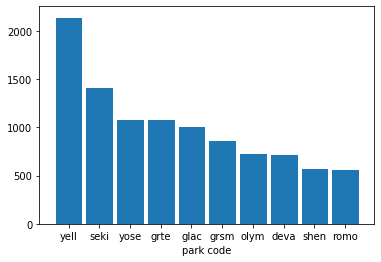

In [32]:
import matplotlib.pyplot as plt


plt.bar(x=supply_park_campground_count['parkCode'][:10], height=supply_park_campground_count['campground_counts'][:10], 
        width=0.9, edgecolor='w')

plt.xlabel('park code')
plt.ylabel('')

plt.show()
#supply_park_campground_count

In [35]:
tot_campsites = sum(supply_park_campground_count['campground_counts'])

print("After a little bit of work we find that there are roughly {0:,} unique campsites in the NPS".format(tot_campsites))

After a little bit of work we find that there are roughly 15,426 unique campsites in the NPS
